# 203_6.2_ランダム・佐々木方策と比較.ipynb

## 6.2 プラットフォーム全体で観測される報酬を最適化する方策学習

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

from dataset import generate_synthetic_data2
from policylearners import IPSBasedGradientPolicyLearner, CateBasedGradientPolicyLearner
from utils import softmax

import math
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.lines import Line2D
from sklearn.model_selection import GridSearchCV

## ランダム方策と佐々木方策の関数定義を行う

### ランダム方策

In [2]:
def calc_random_pg(num_actions, test_data):
    q_x_a_1, q_x_a_0 = test_data["q_x_a_1"], test_data["q_x_a_0"]
    num_data = test_data['num_data']
    pi_random = np.full((num_data, num_actions), 1/num_actions)
    radom_pg = (pi_random * q_x_a_1 + (1 - pi_random) * q_x_a_0).sum(1).mean()
    return radom_pg

### 佐々木方策

In [15]:
def calc_sasaken_pg(offline_logged_data, test_data):
    q_x_a_1, q_x_a_0 = test_data["q_x_a_1"], test_data["q_x_a_0"]
    # データ整形: 観測される情報のみを持つDataFrameを生成する
    x = offline_logged_data['x']
    a = offline_logged_data['a']
    r = offline_logged_data['r']
    pscore = offline_logged_data['pscore']
    combined = np.hstack([x, a.reshape(-1, 1), r.reshape(-1, 1), pscore.reshape(-1, 1)])
    
    # データフレームに変換
    df = pd.DataFrame(combined, columns=[
        'x_0',
        'x_1',
        'x_2',
        'x_3',
        'x_4',
        'a',
        'r',
        'pscore'
    ])
    
    # min_r = df['r'].min()
    # if min_r < 0:
    #     _add = math.ceil(-min_r)
    # else:
    #     _add = 0
    # 
    # df['pseudo_r'] = df['r'] + _add
    
    col = 'r'  # スケーリングしたい列名
    df['pseudo_' + col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    # x_0~x4を説明変数とし、[pseudo_r / pscore]を重みとして、aを予測するモデルを作成する
    # 説明変数と目的変数
    X = np.array(df[[f'x_{i}' for i in range(5)]])  # x_0 ~ x_4
    y = np.array(df['a'])
    sample_weight = np.array(df['pseudo_r']) / np.array(df['pscore'])      # 重み
    
    # モデル作成
    model = LogisticRegression()
    # model = RandomForestClassifier(n_estimators=100, max_depth=5)
    model.fit(X, y, sample_weight=sample_weight)
    
    pi_sasaken = model.predict_proba(test_data['x'])
    sasaken_pg = (pi_sasaken * q_x_a_1 + (1 - pi_sasaken) * q_x_a_0).sum(1).mean()
    return sasaken_pg

### ログデータ(トレーニングデータ)のサイズ$n$を変化させたときの方策性能の変化

In [18]:
## シミュレーション設定
num_runs = 10 # シミュレーションの繰り返し回数

dim_x = 5 # 特徴量xの次元
num_actions = 10 # 行動数, |A|
beta = -0.1 # データ収集方策のパラメータ
max_iter = 21 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)

num_actions_list = [2, 10] # 行動数

num_data_list = [100, 500, 1000, 2000] # トレーニングデータのサイズ

In [19]:
result_df_data_list = []
for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    theta_1 = random_.normal(size=(dim_x, num_actions))
    M_1 = random_.normal(size=(dim_x, num_actions))
    b_1 = random_.normal(size=(1, num_actions))
    theta_0 = random_.normal(size=(dim_x, num_actions))
    M_0 = random_.normal(size=(dim_x, num_actions))
    b_0 = random_.normal(size=(1, num_actions))
    ## 学習された方策の真の性能を近似するためのテストデータを生成
    test_data = generate_synthetic_data2(
        num_data=test_data_size, beta=beta,
        theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
        dim_context=dim_x, num_actions=num_actions, random_state = random_state
    )
    pi_0, q_x_a_1, q_x_a_0 = test_data["pi_0"], test_data["q_x_a_1"], test_data["q_x_a_0"]
    pi_0_value = (pi_0 * q_x_a_1 + (1. - pi_0) * q_x_a_0).sum(1).mean()

    result_df_list = []
    for num_data in num_data_list:
        test_policy_value_list = []
        for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
            ## データ収集方策が形成する分布に従いログデータを生成
            offline_logged_data = generate_synthetic_data2(
                num_data=num_data, beta=beta,
                theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
                dim_context=dim_x, num_actions=num_actions, random_state = _
            )

            true_value_of_learned_policies = dict()
            true_value_of_learned_policies["logging"] = pi_0_value

            ## ログデータを用いてオフ方策学習を実行する
            ### 勾配ベースのアプローチ (IPS推定量で方策勾配を推定)
            ips = IPSBasedGradientPolicyLearner(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            ips.fit(offline_logged_data, test_data)
            pi_ips = ips.predict(test_data)
            true_value_of_learned_policies["ips-pg"] = (pi_ips * q_x_a_1 + (1 - pi_ips) * q_x_a_0).sum(1).mean()
            ### 勾配ベースのアプローチ (新たに開発した推定量で方策勾配を推定)
            cate = CateBasedGradientPolicyLearner(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            cate.fit(offline_logged_data, test_data)
            pi_cate = cate.predict(test_data)
            true_value_of_learned_policies["cate-pg"] = (pi_cate * q_x_a_1 + (1 - pi_cate) * q_x_a_0).sum(1).mean()

            ### ランダム
            true_value_of_learned_policies["random-pg"] = calc_random_pg(num_actions=num_actions, test_data=test_data)

            ### 佐々木オリジナル
            true_value_of_learned_policies["sasaken-pg"] = calc_sasaken_pg(offline_logged_data=offline_logged_data, test_data=test_data)
            
            test_policy_value_list.append(true_value_of_learned_policies)
            
        ## シミュレーション結果の集計
        result_df = DataFrame(test_policy_value_list).stack().reset_index(1)\
            .rename(columns={"level_1": "method", 0: "value"})
        result_df["num_data"] = num_data
        result_df["pi_0_value"] = pi_0_value
        result_df["rel_value"] = result_df["value"] / pi_0_value
        result_df_list.append(result_df)
    result_df_data_list.append(pd.concat(result_df_list).reset_index(level=0))

num_data=2000...: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


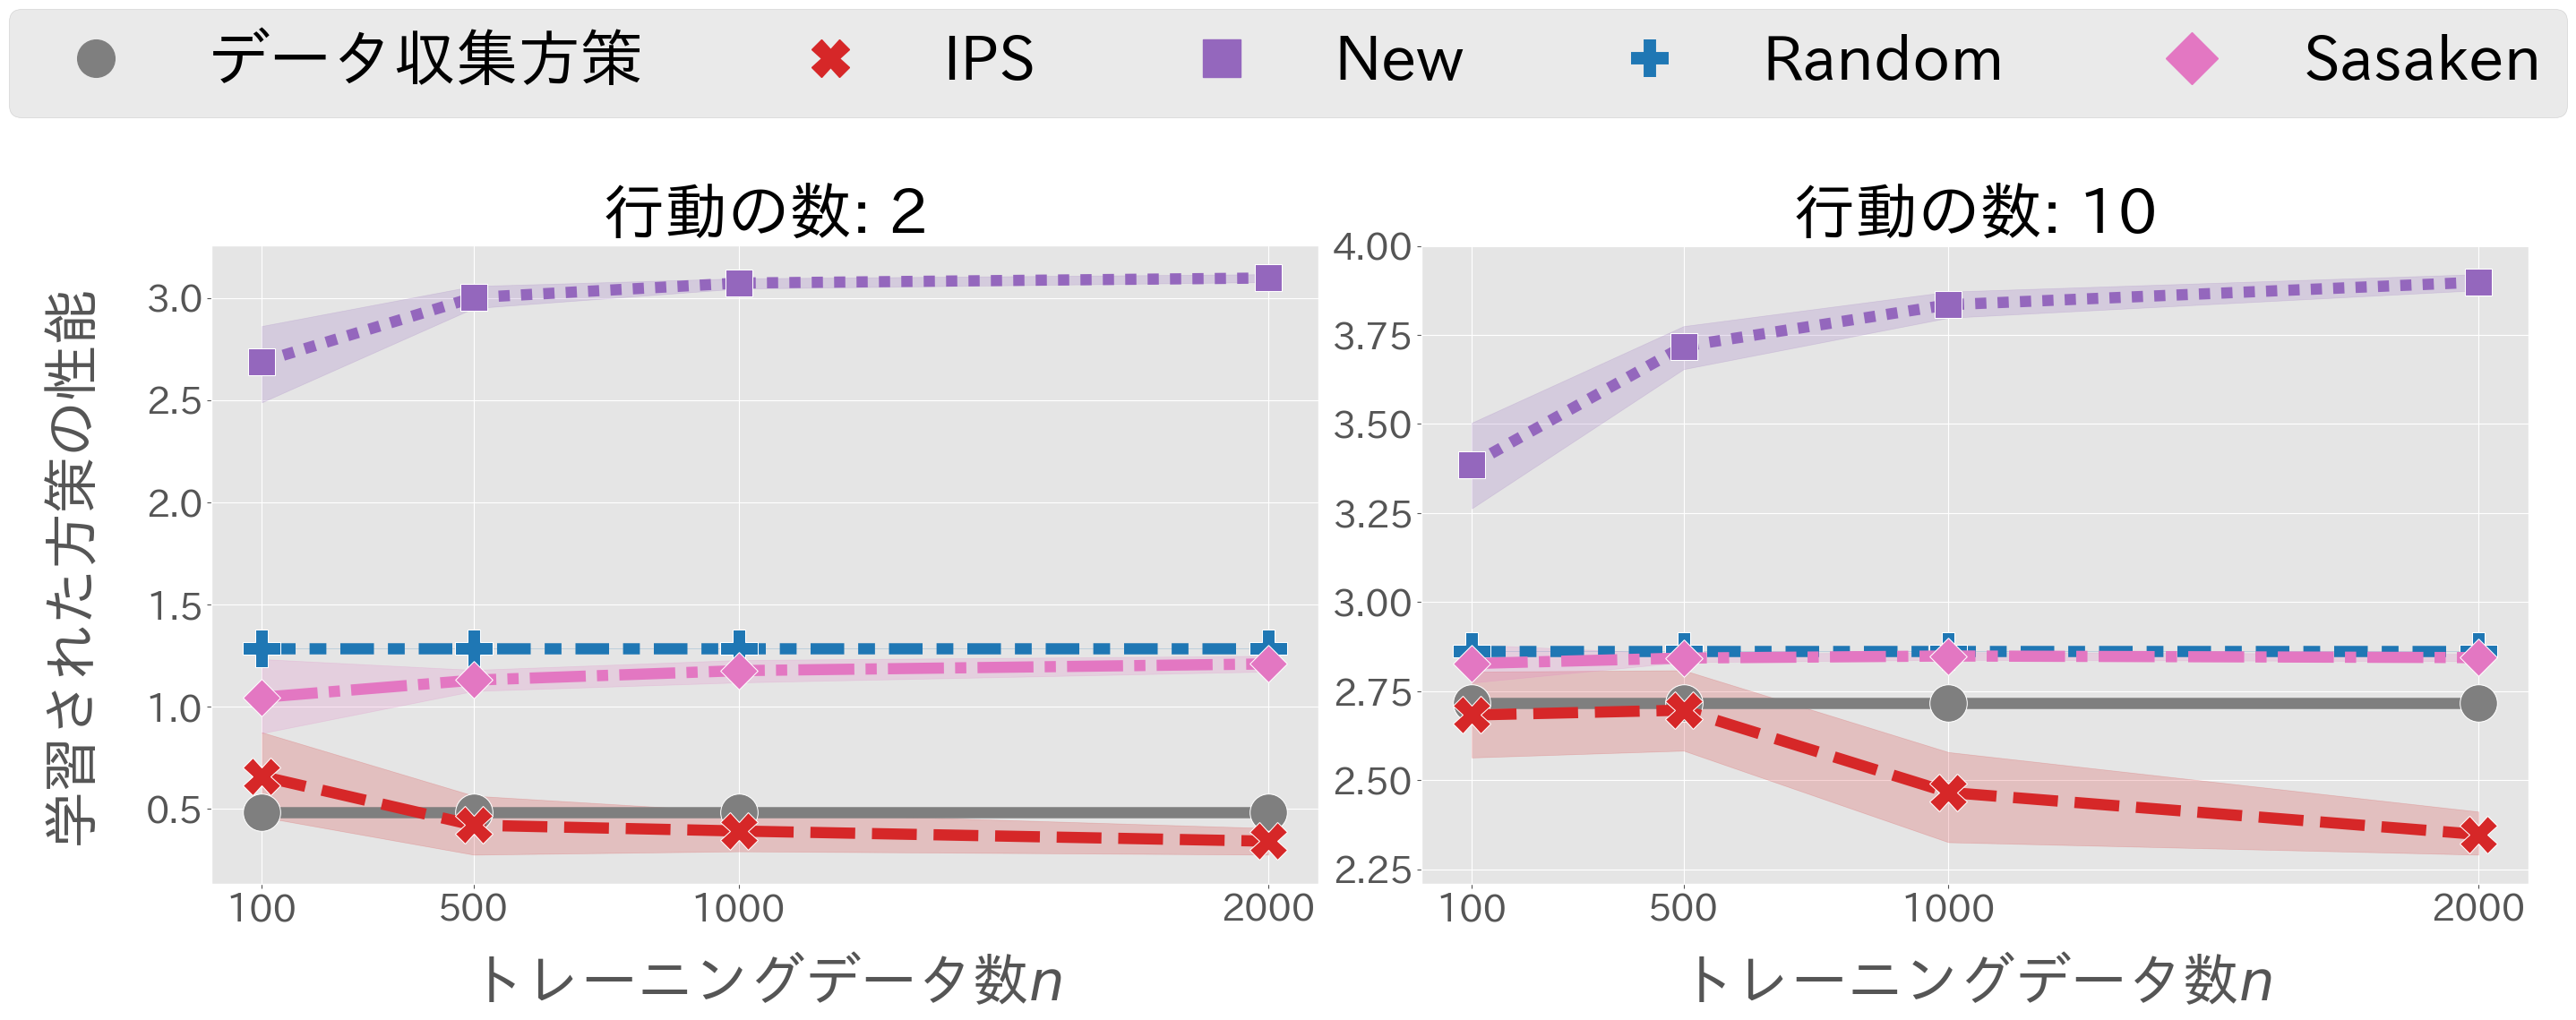

In [20]:
fig, ax_list = plt.subplots(1, len(num_actions_list), figsize=(28, 9.5), tight_layout=True)
for i, (num_actions, result_df) in enumerate(zip(num_actions_list, result_df_data_list)):
    ax = ax_list[i]
    sns.lineplot(
        linewidth=9,
        markersize=30,
        markers=True,
        x="num_data",
        y="value",
        hue="method",
        style="method",
        ax=ax,
        palette=["tab:grey", "tab:red", "tab:purple", "tab:blue", "tab:pink"],
        legend=False,
        data=result_df,
    )
    ax.set_title(f"行動の数: {num_actions}", fontsize=50)
    # yaxis
    if i == 0:
        ax.set_ylabel("学習された方策の性能", fontsize=45)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xlabel("トレーニングデータ数$n$", fontsize=45)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.11)
# fig.legend(["データ収集方策", "IPS", "New"], fontsize=50, bbox_to_anchor=(0.5, 1.13), ncol=5, loc="center")

custom_lines = [
    Line2D([0], [0], color="tab:grey", marker='o', markersize=30, linestyle='None', label="データ収集方策"),
    Line2D([0], [0], color="tab:red", marker='X', markersize=30, linestyle='None', label="IPS"),
    Line2D([0], [0], color="tab:purple", marker='s', markersize=30, linestyle='None', label="New"),
    Line2D([0], [0], color="tab:blue", marker='+', markersize=30, markeredgewidth=10, linestyle='None', label="Random"),
    Line2D([0], [0], color="tab:pink", marker='D', markersize=30, linestyle='None', label="Sasaken"),
]

fig.legend(
    handles=custom_lines,
    fontsize=50,
    bbox_to_anchor=(0.5, 1.13),
    ncol=5,
    loc="center"
)